In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os
from training.feature_extraction import extract_features  # your multi-dim function
from training.preprocess import _group_and_window, preprocess_and_window_with_dates, _group_and_window_with_dates, get_first_window_test_set
from utils.bilstm import data_reshape
project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))  # return the projest's root folder
sys.path.append(project_root)
from utils import data_reshape, split_helper, load_parameters

2025-05-05 11:24:55.737087: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 11:24:55.737927: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-05 11:24:55.740600: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-05 11:24:55.747812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746437095.759965 3633217 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746437095.76

In [2]:
import pandas as pd
import numpy as np
import pickle
from functools import partial
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#!/usr/bin/env python
# coding: utf-8

"""
A script/notebook to compare BiLSTM vs LightGBM across multiple window sizes
for one or more datasets (e.g. 'st', 'randomized').
Assumes:
 - Each window-specific BiLSTM model is saved at models/bilstm/{dataset}_bilstm_win{w}.h5
 - The single LightGBM model is saved at models/lightgbm/{dataset}_model.pkl
 - multi_window_size is defined in your .yaml files
 - The same data_path + CSV structure is used for test sets
"""
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# Local modules (adjust imports if your structure is different)
from training.preprocess import preprocess_and_window, load_parameters
from training.feature_extraction import extract_features

In [3]:
# BILSTM model -----------------------------------------------------------------------
# the input features of the BiLSTM model
features_bilstm = ['voltage', 'current', 'temperature', 'relativeTime']
labels_bilstm = ['capacity']

# load the model


# the BiLSTM model's input features need to be normalized
folder_path = 'data/st/'
path_dict = {'train': f'{folder_path}train.csv',
             'valid': f'{folder_path}valid.csv',
             'test': f'{folder_path}test.csv'}
data_dict = {key: pd.read_csv(path) for key, path in path_dict.items()}
data = pd.concat(data_dict, axis=0)
scaler = MinMaxScaler()
data[features_bilstm] = scaler.fit_transform(data[features_bilstm])
# split tha dataset into train, valid, test
#unique_cycles = data['cycle'].unique()
# Example: 70% train+val, 30% test
#trainval_cycles, test_cycles = train_test_split(
#    unique_cycles, test_size=0.2, random_state=42
#)
test_lgb = pd.read_csv('data/st/test.csv')
# BILSTM model ------------------------------------------------------------------------



In [4]:
train = pd.read_csv('data/st/train.csv')
valid = pd.read_csv('data/st/valid.csv')
test_bilstm = pd.read_csv('data/st/test.csv')

scaler = MinMaxScaler()
train[features_bilstm] = scaler.fit_transform(train[features_bilstm])
valid[features_bilstm] = scaler.transform(valid[features_bilstm])


In [5]:
# LightGBM model -----------------------------------------------------------------------
# the input features of the LightGBM model
params = load_parameters('training/lightgbm.yaml').datasets['st']
features_lgb = params['feature_list']
labels_lgb = params['labels']

# load the model
# with open('model_lightgbm/model_pruning/pruned_nasa_3features_first20_01886500/pruned_110trees_0199.pkl', 'rb') as file:
#     model_lgb = pickle.load(file)
with open('result/models/lightgbm/lgbm_st_model.pkl', 'rb') as file:
    model_lgb = pickle.load(file)

# the testing data
test_lgb = pd.read_csv('data/st/test.csv')
# LightGBM model -----------------------------------------------------------------------

In [6]:
data_groupby = params['data_groupby']
# step_len_list = [5, 10, 15, 20, 30, 40, 50, 70, 100]
step_len_list = [20]
# step_len_list = [5, 10, 15, 20, 30, 40, 50]

# get the group size
group_sizes = test_lgb.groupby(data_groupby).size()
max_group_length, min_group_length = group_sizes.max(), group_sizes.min()
print(f"--group length: max={max_group_length}, min={min_group_length}\n")
fixed_group_length = min_group_length

# test and save the result onto dataframe
columns = ['model', 'step_length', 'ordinal', 'MAE', 'loss']
result = pd.DataFrame(columns=columns)

--group length: max=360, min=175



In [7]:
# ---------------------------------------------------------------------
# 5) Build 20-sample windows from the test set
# ---------------------------------------------------------------------
step_len = 20  # Your chosen fixed window length
overlap = 0    # No overlap, so it slices [0..19], [20..39], etc.
X_list, y_list = [], []
'''X_list, y_list, test_dates = _group_and_window_with_dates(
        df=test_lgb,  # test data
        features=params['raw_features'],   # columns used as raw input
        labels=params['labels'],           # columns for target
        window_length=step_len,
        overlap=overlap,
        date_col=params['date_col'],  # date column
        group_cols=params['data_groupby']
    )'''

model_bilstm_path = 'result/models/bilstm/st_bilstm_'
model_bilstm_dict = {
    '5': f'{model_bilstm_path}win5.h5',
    '10': f'{model_bilstm_path}win10.h5',
    #'15': f'{model_bilstm_path}15.keras',
    '20': f'{model_bilstm_path}win20.h5',
    #'20': f'download/ST_BiLSTM_st.keras',
    '30': f'{model_bilstm_path}win30.h5',
    '40': f'{model_bilstm_path}win40.h5',
    '50': f'{model_bilstm_path}win50.h5',
}
model_bilstm = tf.keras.models.load_model(model_bilstm_dict['20'], custom_objects={'mae': MeanAbsoluteError()})

results = []

max_windows_per_group = (
    pd.read_csv(os.path.join(params["data_path"], "test.csv"))
      .groupby(params["data_groupby"]).size().max() // step_len
)

for win_idx in range(max_windows_per_group):
    start = win_idx * step_len
    end   = start + step_len
    
    x, X_test_windows_bilstm, y = get_first_window_test_set(params['data_path'], start_len=start, end_len=end, features=params['raw_features'], labels=params['labels'], data_groupby=params['data_groupby'], scaler = scaler)    
        
    # X_list is a list of arrays each shaped (20, len(raw_features))
    # y_list is a list of scalars (if 1D label)

    if len(x) == 0:
        print(f"No 20-sample windows created from the test data in sample {i} cobtinue.")
        continue

    # Convert to NumPy
    #X_test_windows = np.array(X_list, dtype=np.float32)    # shape => (N_windows, 20, len(raw_features))
    #y_test_windows = np.array(y_list, dtype=np.float32)    # shape => (N_windows,)

    #X_test_windows_bilstm = np.array([scaler.transform(X_list[i]) for i in range(len(X_list))],)
    '''X_test_windows_bilstm = np.array([
        scaler.transform(pd.DataFrame(x, columns=params['raw_features']))
        for i in range(len(X_list))
    ], dtype=np.float32)'''
    # ---------------------------------------------------------------------
    # 6) LightGBM Prediction: First extract features from (N_windows, 20, #features)
    # ---------------------------------------------------------------------
    print(x.shape)
    X_test_lgb = extract_features(
        data=x,
        raw_features=params['raw_features'],
        feature_list=params['feature_list']
    )
    if len(X_test_lgb) <=1:
        print("No features extracted from the test data. Continue.")
        continue
    # shape => (N_windows, extracted_feature_dim)

    preds_lgb = model_lgb.predict(X_test_lgb)  # shape => (N_windows,)

    # Per-window absolute errors
    abs_err_lgb = np.abs(preds_lgb.ravel() - y.ravel())


    
    #model_bilstm = tf.keras.models.load_model("models/bilstm/ST_BiLSTM_st.keras", custom_objects={'mae': MeanAbsoluteError()})
    # ---------------------------------------------------------------------
    # 7) BiLSTM Prediction: Feed raw (N_windows, 20, #features) directly
    # ---------------------------------------------------------------------
    preds_bilstm = model_bilstm.predict(X_test_windows_bilstm)  # shape => (N_windows,)
    abs_err_bilstm = np.abs(preds_bilstm.ravel() - y.ravel())


    # ---------------------------------------------------------------------
    # 8) Build a result DataFrame and plot the per-window MAE
    # ---------------------------------------------------------------------
    N_windows = len(x)

    
    #for i in range(N_windows):
    # "ordinal" is just the i-th window (1-based index)
    ordinal = win_idx  # // step_len
    results.append({
        "model": "lgb",
        "step_length": step_len,
        "ordinal": ordinal,
        "MAE": abs_err_lgb
    })
    results.append({
        "model": "bilstm",
        "step_length": step_len,
        "ordinal": ordinal,
        "MAE": abs_err_bilstm
    })

df_results = pd.DataFrame(results)

# Plot
# Plot

# To resolve the warnings, ensure that the input to the scaler has valid feature names.
# Use a DataFrame instead of a NumPy array for transformation.

# ---------------------------------------------------------------------
# 9) (Optional) Print Overall MAE
# ---------------------------------------------------------------------
#lgb_better = (abs_err_lgb < abs_err_bilstm).sum()/ len(abs_err_lgb)*100
#bilstm_better = (abs_err_bilstm < abs_err_lgb).sum()

#print(f"Number of points where LightGBM outperforms BiLSTM: {lgb_better}%")
#print(f"Number of points where BiLSTM outperforms LightGBM: {bilstm_better}")
#print()
'''avg_mae_lgb = abs_err_lgb.mean()
avg_mae_bilstm = abs_err_bilstm.mean()
print(f"LightGBM - overall MAE at wlen=20: {avg_mae_lgb:.4f}")
print(f"BiLSTM   - overall MAE at wlen=20: {avg_mae_bilstm:.4f}")'''

W0000 00:00:1746437097.174832 3633217 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batte

(33, 20, 4)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
(33, 20, 4)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(33, 20, 4)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with featur

(33, 20, 4)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(33, 20, 4)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with

(33, 20, 4)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(33, 20, 4)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(33, 20, 4)


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(26, 20, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
(25, 20, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with featur

(25, 20, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
(25, 20, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with featur

(19, 20, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
(14, 20, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with featur

(9, 20, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
(6, 20, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with featur

(2, 20, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
(1, 20, 4)
No features extracted from the test data. Continue.


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with featur

'avg_mae_lgb = abs_err_lgb.mean()\navg_mae_bilstm = abs_err_bilstm.mean()\nprint(f"LightGBM - overall MAE at wlen=20: {avg_mae_lgb:.4f}")\nprint(f"BiLSTM   - overall MAE at wlen=20: {avg_mae_bilstm:.4f}")'

0    [0.06289138028137975, 0.017333037208219215, 0....
2    [0.00462908125876238, 0.01244440364607513, 0.0...
4    [0.001010560817254147, 0.009457848120903778, 0...
6    [0.012677506365711633, 0.009927632657110719, 0...
8    [0.00034762586367564907, 0.01039335770050931, ...
Name: MAE, dtype: object
1    [0.023317575, 0.007318616, 0.011635542, 0.0118...
3    [0.05420804, 0.041657925, 0.019699454, 0.02131...
5    [0.026962042, 0.01781094, 0.0057805777, 0.0039...
7    [0.024006844, 0.017088413, 0.0053930283, 0.002...
9    [0.032850146, 0.027676225, 0.0048447847, 0.008...
Name: MAE, dtype: object


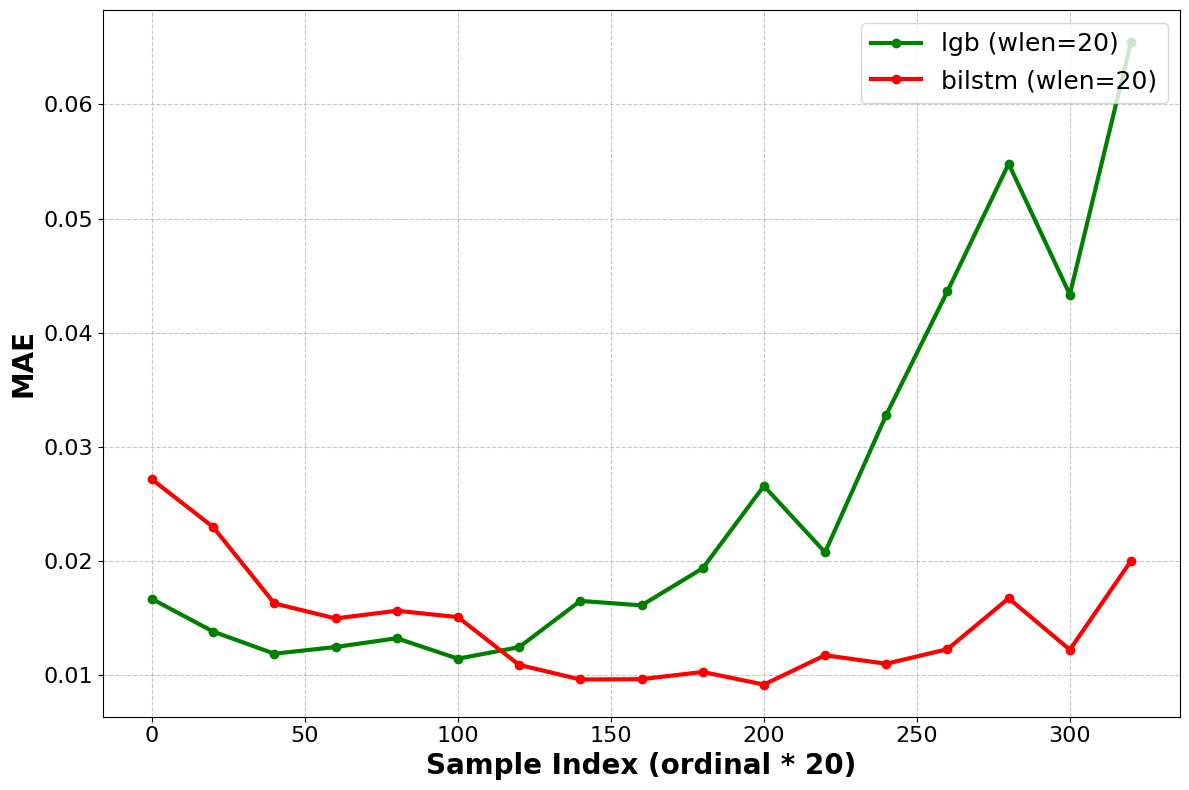

In [8]:
plt.figure(figsize=(12, 8))  # Larger figure size for better visibility
#plt.style.use('seaborn-whitegrid')  # Professional style

for model_name in df_results["model"].unique():
    # Subset for each model
    subset = df_results[df_results["model"] == model_name]
    # For X, you can multiply ordinal by 20 to reflect the sample index in the series
    xvals = subset["ordinal"] * step_len
    yvals = subset["MAE"]
    print(yvals[:5])
    plt.plot(
        xvals[:], 
        np.array([yvals[i].mean() for i in yvals.index]),
        marker="o",
        linestyle="-",
        label=f"{model_name} (wlen=20)",
        linewidth=3,  # Thicker line for better visibility
        color='green' if model_name == 'lgb' else 'red'
    )

# Axis labels
plt.xlabel("Sample Index (ordinal * 20)", fontsize=20, fontweight='bold')
plt.ylabel("MAE", fontsize=20, fontweight='bold')

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=18, loc='upper right')

# Tick parameters
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Save the figure in high resolution for publication
plt.tight_layout()
#plt.savefig("MAE_comparison_plot.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [9]:
'''

##############################################################################
# 1) Choose which datasets to evaluate
##############################################################################
# If you only have 'st' and 'randomized', set them here:
DATASETS = ["st", "randomized"]  # or just ["st"] if you only want one.

##############################################################################
# 2) Prepare a figure for subplots (one subplot per dataset)
##############################################################################
fig, axes = plt.subplots(nrows=len(DATASETS), ncols=1, figsize=(8, 5 * len(DATASETS)), sharex=True, sharey=False)

if not isinstance(axes, np.ndarray):
    # If there's only one dataset in the list, 'axes' won't be an array.
    axes = [axes]  # make it iterable

##############################################################################
# 3) Loop over each dataset, evaluate BiLSTM vs LightGBM across windows
##############################################################################
for i, ds_name in enumerate(DATASETS):
    ax = axes[i]
    print(f"\n\n=== Evaluating dataset: {ds_name} ===\n")

    ##########################################################################
    # 3.1) Load configurations for BiLSTM and LightGBM
    #      We'll read both YAML files to get the needed info.
    ##########################################################################
    params_bilstm = load_parameters("training/bilstm.yaml", dataset_override=ds_name)
    params_lgb    = load_parameters("training/lightgbm.yaml", dataset_override=ds_name)

    # We'll gather the window sizes from the same config you used to train them.
    # Typically, you'd find these in both configs, or just pick one of them.
    window_sizes = []
    if hasattr(params_bilstm, "multi_window_size"):
        window_sizes = params_bilstm.multi_window_size[:]
    elif hasattr(params_lgb, "multi_window_size"):
        window_sizes = params_lgb.multi_window_size[:]
    else:
        # fallback if no multi_window_size
        window_sizes = [params_bilstm.sequence_length]

    print(f"Window sizes to evaluate: {window_sizes}")

    ##########################################################################
    # 3.2) Load LightGBM model
    ##########################################################################
    lgbm_model_path = f"models/lightgbm/lgbm_{ds_name}_model.pkl"
    if not os.path.exists(lgbm_model_path):
        print(f"WARNING: LightGBM model not found: {lgbm_model_path}")
        print("Skipping LightGBM evaluation...")
        lgbm_maes = [None] * len(window_sizes)
        lightgbm_available = False
    else:
        with open(lgbm_model_path, "rb") as f:
            lgbm_model = pickle.load(f)
        lightgbm_available = True
        lgbm_maes = []

    ##########################################################################
    # 3.3) Evaluate BiLSTM across multiple window sizes
    ##########################################################################
    bilstm_maes = []
    for w in window_sizes:
        print(f"\n--- Window size = {w} ---")

        ######################################################################
        # (a) Prepare test data for that window
        ######################################################################
        # BILSTM uses the raw numeric windows from `params_bilstm.features`
        ( _, _, _, _, test_s_bi, test_t_bi, _, _, _) = preprocess_and_window_with_dates(
            data_path    = params_bilstm.data_path,
            sequence_length = w,
            overlap      = params_bilstm.overlap,
            normalize    = params_bilstm.normalize,
            features     = params_bilstm.features,
            labels       = params_bilstm.labels,
            date_col     = params_bilstm.date_col,
            data_groupby = params_bilstm.data_groupby
        )
        print(f"  BILSTM Test data shape: {test_s_bi.shape}")

        # (b) Load the BiLSTM model for this window size
        bilstm_path = f"models/bilstm/{ds_name}_bilstm_win{w}.h5"
        if not os.path.exists(bilstm_path):
            print(f"  WARNING: BiLSTM model not found at {bilstm_path}")
            bilstm_maes.append(None)
        else:
            bilstm_model = tf.keras.models.load_model(bilstm_path, custom_objects={'mae': MeanSquaredError()})
            pred_bi = bilstm_model.predict(test_s_bi)
            mae_bi = mean_absolute_error(test_t_bi, pred_bi)
            bilstm_maes.append(mae_bi)
            print(f"  BILSTM Test MAE: {mae_bi:.6f}")

        ######################################################################
        # (c) Evaluate LightGBM for this window size (same test *samples*)
        ######################################################################
        if lightgbm_available:
            # LightGBM was trained on extracted features, so do the same extraction
            ( _, _, _, _, test_s_lgb, test_t_lgb, _, _, _) = preprocess_and_window_with_dates(
                data_path    = params_lgb.data_path,
                sequence_length = w,
                overlap      = params_lgb.overlap,
                normalize    = params_lgb.normalize,
                features     = params_lgb.raw_features,
                labels       = params_lgb.labels,
                date_col     = params_lgb.date_col,
                data_groupby = params_lgb.data_groupby
            )
            # Convert raw windows to final feature set
            test_s_lgb = extract_features(test_s_lgb, params_lgb.raw_features, params_lgb.feature_list)
            print(f"  LightGBM Test data shape (extracted features): {test_s_lgb.shape}")

            lgb_pred = lgbm_model.predict(test_s_lgb)
            mae_lgb = mean_absolute_error(test_t_lgb, lgb_pred)
            lgbm_maes.append(mae_lgb)
            print(f"  LightGBM Test MAE: {mae_lgb:.6f}")

    ##########################################################################
    # 3.4) Plot the results for this dataset
    ##########################################################################
    # Some datasets might not have valid LightGBM or BILSTM arrays, so handle that:
    if len(bilstm_maes) == len(window_sizes):
        ax.plot(window_sizes, bilstm_maes, marker='o', label='BiLSTM MAE')
    if lightgbm_available and len(lgbm_maes) == len(window_sizes):
        ax.plot(window_sizes, lgbm_maes, marker='x', label='LightGBM MAE')

    ##############################################################################
    # 3.4) Plot the results for this dataset
    ##############################################################################
    # Some datasets might not have valid LightGBM or BILSTM arrays, so handle that:
    if len(bilstm_maes) == len(window_sizes):
        ax.plot(window_sizes, bilstm_maes, marker='o', label='BiLSTM MAE')
    if lightgbm_available and len(lgbm_maes) == len(window_sizes):
        ax.plot(window_sizes, lgbm_maes, marker='x', label='LightGBM MAE')

    # Add the dataset name to the right of each subplot
    ax.text(1.02, 0.5, ds_name.upper(), transform=ax.transAxes, fontsize=20, va='center', ha='left', rotation=270)

    ##############################################################################

    #ax.set_title(f"Dataset: {ds_name}")
    #ax.set_xlabel("Window Size")
    #if i == 0:
    #    ax.set_ylabel("MAE")
    #ax.legend()
    #############################################################################
# 4) Final display
##############################################################################
#plt.tight_layout()
#plt.show()
# Enhance the figure for publication
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)  # Add gridlines for better readability
    ax.spines['top'].set_visible(False)  # Remove the top spine
    ax.spines['right'].set_visible(False)  # Remove the right spine
    ax.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label size
    ax.set_facecolor('#f9f9f9')  # Set a light background color for better contrast

# Add a super title for the entire figure
#fig.suptitle("Comparison of BiLSTM and LightGBM Across Window Sizes", fontsize=16, fontweight='bold')

# Add a common x-axis label
fig.text(0.5, 0.02, 'Window Size', ha='center', fontsize=20, rotation='horizontal')

# Add a common y-axis label
fig.text(-0.02, 0.5, 'MAE', va='center', rotation='vertical', fontsize=20)

# Adjust layout for better spacing
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure in high resolution for publication
#plt.savefig("comparison_plot.png", dpi=300, bbox_inches='tight')

# Adjust layout for better spacing and remove overlapping x-axis labels
plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=0.5)

# Remove x-axis labels for the first subplot
axes[0].set_xlabel("")

# Display the figure
plt.show()
#plt.show()
# Create a new figure for the specific case of window size 25
'''

'\n\n##############################################################################\n# 1) Choose which datasets to evaluate\n##############################################################################\n# If you only have \'st\' and \'randomized\', set them here:\nDATASETS = ["st", "randomized"]  # or just ["st"] if you only want one.\n\n##############################################################################\n# 2) Prepare a figure for subplots (one subplot per dataset)\n##############################################################################\nfig, axes = plt.subplots(nrows=len(DATASETS), ncols=1, figsize=(8, 5 * len(DATASETS)), sharex=True, sharey=False)\n\nif not isinstance(axes, np.ndarray):\n    # If there\'s only one dataset in the list, \'axes\' won\'t be an array.\n    axes = [axes]  # make it iterable\n\n##############################################################################\n# 3) Loop over each dataset, evaluate BiLSTM vs LightGBM across windows\n#########



=== Evaluating dataset: st ===

Window sizes to evaluate: [20, 30, 40, 50, 60]



--- Window size = 20 ---
  BILSTM Test data shape: (416, 20, 4)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
  BILSTM Test MAE: 0.014797


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (416, 10)
  LightGBM Test MAE: 0.018774

--- Window size = 30 ---
  BILSTM Test data shape: (269, 30, 4)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
  BILSTM Test MAE: 0.019277


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (269, 10)
  LightGBM Test MAE: 0.015571

--- Window size = 40 ---
  BILSTM Test data shape: (203, 40, 4)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
  BILSTM Test MAE: 0.033960
  LightGBM Test data shape (extracted features): (203, 10)


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test MAE: 0.013688

--- Window size = 50 ---
  BILSTM Test data shape: (160, 50, 4)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
  BILSTM Test MAE: 0.024247
  LightGBM Test data shape (extracted features): (160, 10)
  LightGBM Test MAE: 0.017090

--- Window size = 60 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (127, 60, 4)
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x75def8b1bc70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
  BILSTM Test MAE: 0.031691
  LightGBM Test data shape (extracted features): (127, 10)
  LightGBM Test MAE: 0.017303


=== Evaluating dataset: randomized ===

Window sizes to evaluate: [20, 30, 40, 50, 60]

--- Window size = 20 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (340, 20, 4)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
  BILSTM Test MAE: 2.044636


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (340, 10)
  LightGBM Test MAE: 2.256100

--- Window size = 30 ---
  BILSTM Test data shape: (218, 30, 4)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
  BILSTM Test MAE: 3.740715


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (218, 10)
  LightGBM Test MAE: 2.207846

--- Window size = 40 ---
  BILSTM Test data shape: (161, 40, 4)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
  BILSTM Test MAE: 17.645147
  LightGBM Test data shape (extracted features): (161, 10)
  LightGBM Test MAE: 2.183140

--- Window size = 50 ---
  BILSTM Test data shape: (123, 50, 4)


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
  BILSTM Test MAE: 17.734785
  LightGBM Test data shape (extracted features): (123, 10)
  LightGBM Test MAE: 1.881152

--- Window size = 60 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (100, 60, 4)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
  BILSTM Test MAE: 18.969215
  LightGBM Test data shape (extracted features): (100, 10)
  LightGBM Test MAE: 1.750911


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipykernel_3633217/4279689235.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.5)


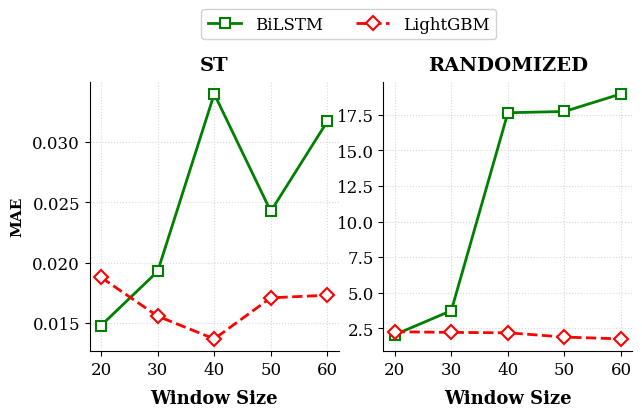

In [10]:
# Configuration
DATASETS = ["st", "randomized"]  # Datasets to compare
COLORS = ['green', 'red']  # Blue/orange color scheme
STYLE_PARAMS = {
    'axes.labelpad': 8,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'font.family': 'serif'
}
plt.rcParams.update(STYLE_PARAMS)

# Initialize figure
fig, axes = plt.subplots(nrows=1, ncols=len(DATASETS), 
                        figsize=(3.5*len(DATASETS), 3.5),
                        sharey=False, gridspec_kw={'wspace': 0.18})
axes = np.array(axes).flatten()


for i, ds_name in enumerate(DATASETS):
    ax = axes[i]
    print(f"\n\n=== Evaluating dataset: {ds_name} ===\n")

    ##########################################################################
    # 3.1) Load configurations for BiLSTM and LightGBM
    #      We'll read both YAML files to get the needed info.
    ##########################################################################
    params_bilstm = load_parameters("training/bilstm.yaml", dataset_override=ds_name)
    params_lgb    = load_parameters("training/lightgbm.yaml", dataset_override=ds_name)

    # We'll gather the window sizes from the same config you used to train them.
    # Typically, you'd find these in both configs, or just pick one of them.
    wparams_bilstm = load_parameters("training/bilstm.yaml", dataset_override=ds_name)
    params_lgb = load_parameters("training/lightgbm.yaml", dataset_override=ds_name)
    
    # Window size determination
    window_sizes = (params_bilstm.multi_window_size if hasattr(params_bilstm, "multi_window_size") 
                    else [params_bilstm.sequence_length])

    print(f"Window sizes to evaluate: {window_sizes}")

    ##########################################################################
    # 3.2) Load LightGBM model
    ##########################################################################
    lgbm_model_path = f"result/models/lightgbm/lgbm_{ds_name}_model.pkl"
    if not os.path.exists(lgbm_model_path):
        print(f"WARNING: LightGBM model not found: {lgbm_model_path}")
        print("Skipping LightGBM evaluation...")
        lgbm_maes = [None] * len(window_sizes)
        lightgbm_available = False
    else:
        with open(lgbm_model_path, "rb") as f:
            lgbm_model = pickle.load(f)
        lightgbm_available = True
        lgbm_maes = []

    ##########################################################################
    # 3.3) Evaluate BiLSTM across multiple window sizes
    ##########################################################################
    bilstm_maes = []
    for w in window_sizes:
        print(f"\n--- Window size = {w} ---")

        ######################################################################
        # (a) Prepare test data for that window
        ######################################################################
        # BILSTM uses the raw numeric windows from `params_bilstm.features`
        ( _, _, _, _, test_s_bi, test_t_bi, _, _, _) = preprocess_and_window_with_dates(
            data_path    = params_bilstm.data_path,
            sequence_length = w,
            overlap      = params_bilstm.overlap,
            normalize    = params_bilstm.normalize,
            features     = params_bilstm.features,
            labels       = params_bilstm.labels,
            date_col     = params_bilstm.date_col,
            data_groupby = params_bilstm.data_groupby
        )
        print(f"  BILSTM Test data shape: {test_s_bi.shape}")

        # (b) Load the BiLSTM model for this window size
        bilstm_path = f"result/models/bilstm/{ds_name}_bilstm_win{w}.h5"
        if not os.path.exists(bilstm_path):
            print(f"  WARNING: BiLSTM model not found at {bilstm_path}")
            bilstm_maes.append(None)
        else:
            bilstm_model = tf.keras.models.load_model(bilstm_path, custom_objects={'mae': MeanSquaredError()})
            pred_bi = bilstm_model.predict(test_s_bi)
            mae_bi = mean_absolute_error(test_t_bi, pred_bi)
            bilstm_maes.append(mae_bi)
            print(f"  BILSTM Test MAE: {mae_bi:.6f}")

        ######################################################################
        # (c) Evaluate LightGBM for this window size (same test *samples*)
        ######################################################################
        if lightgbm_available:
            # LightGBM was trained on extracted features, so do the same extraction
            ( _, _, _, _, test_s_lgb, test_t_lgb, _, _, _) = preprocess_and_window_with_dates(
                data_path    = params_lgb.data_path,
                sequence_length = w,
                overlap      = params_lgb.overlap,
                normalize    = params_lgb.normalize,
                features     = params_lgb.raw_features,
                labels       = params_lgb.labels,
                date_col     = params_lgb.date_col,
                data_groupby = params_lgb.data_groupby
            )
            # Convert raw windows to final feature set
            test_s_lgb = extract_features(test_s_lgb, params_lgb.raw_features, params_lgb.feature_list)
            print(f"  LightGBM Test data shape (extracted features): {test_s_lgb.shape}")

            lgb_pred = lgbm_model.predict(test_s_lgb)
            mae_lgb = mean_absolute_error(test_t_lgb, lgb_pred)
            lgbm_maes.append(mae_lgb)
            print(f"  LightGBM Test MAE: {mae_lgb:.6f}")
            

        # --- Optimized Plotting ---
    ax.plot(window_sizes, bilstm_maes, 's-', color=COLORS[0], markersize=7,
            linewidth=2, markerfacecolor='white', markeredgewidth=1.5,
            label='BiLSTM')
    ax.plot(window_sizes, lgbm_maes, 'D--', color=COLORS[1], markersize=7,
            linewidth=2, markerfacecolor='white', markeredgewidth=1.5,
            label='LightGBM')
    
    # Axis styling
    ax.set_title(ds_name.upper(), pad=8, weight='bold', fontsize=14)
    ax.set_xlabel("Window Size", labelpad=8, weight='bold', fontsize=13)
    if i == 0:
        ax.set_ylabel("MAE", labelpad=6, weight='bold', fontsize=11)
    ax.set_xticks(window_sizes)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, alpha=0.5, linestyle=':')
    
    # Remove frame borders
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    
    # Add legend to first subplot only
    if i == 0:
        ax.legend(frameon=True, framealpha=0.9, 
            loc='upper center', bbox_to_anchor=(1.04, 1.3),
            ncol=2, fontsize=12, title_fontsize=12)

# Final layout adjustments
plt.tight_layout(pad=1.5)
plt.savefig("result/figures/model_comparison.pdf", dpi=300, bbox_inches='tight', transparent=True)
plt.show()



=== Evaluating dataset: st ===



  BILSTM Test MAE: 0.468854


  BILSTM Test MAE: 0.055603


  BILSTM Test MAE: 0.092716


  BILSTM Test MAE: 0.346162
  BILSTM Test MAE: 0.334529


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test MAE: 0.053945


  BILSTM Test MAE: 0.158509


  BILSTM Test MAE: 0.021971


  BILSTM Test MAE: 0.034121


  BILSTM Test MAE: 0.087905
  BILSTM Test MAE: 0.081765
  LightGBM Test MAE: 0.022759


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test MAE: 0.203146


  BILSTM Test MAE: 0.032050


  BILSTM Test MAE: 0.027997


  BILSTM Test MAE: 0.034939
  BILSTM Test MAE: 0.042023
  LightGBM Test MAE: 0.024520


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test MAE: 0.192145


  BILSTM Test MAE: 0.044952


  BILSTM Test MAE: 0.034684


  BILSTM Test MAE: 0.041642
  BILSTM Test MAE: 0.040473
  LightGBM Test MAE: 0.095141


=== Evaluating dataset: randomized ===



/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test MAE: 7.899181


  BILSTM Test MAE: 18.806049


  BILSTM Test MAE: 18.006134


  BILSTM Test MAE: 18.375683
  BILSTM Test MAE: 19.229948


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test MAE: 4.600658


  BILSTM Test MAE: 2.460853


  BILSTM Test MAE: 3.680876


  BILSTM Test MAE: 17.774542


  BILSTM Test MAE: 18.146833
  BILSTM Test MAE: 19.001154
  LightGBM Test MAE: 2.295927


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test MAE: 2.515157


  BILSTM Test MAE: 3.423460


  BILSTM Test MAE: 17.744539


  BILSTM Test MAE: 18.099020
  BILSTM Test MAE: 18.921803
  LightGBM Test MAE: 1.725856


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test MAE: 3.466888


  BILSTM Test MAE: 3.676945


  BILSTM Test MAE: 17.166054


  BILSTM Test MAE: 17.515114
  BILSTM Test MAE: 18.310883
  LightGBM Test MAE: 2.334848


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


TypeError: Legend.__init__() got an unexpected keyword argument 'nrows'

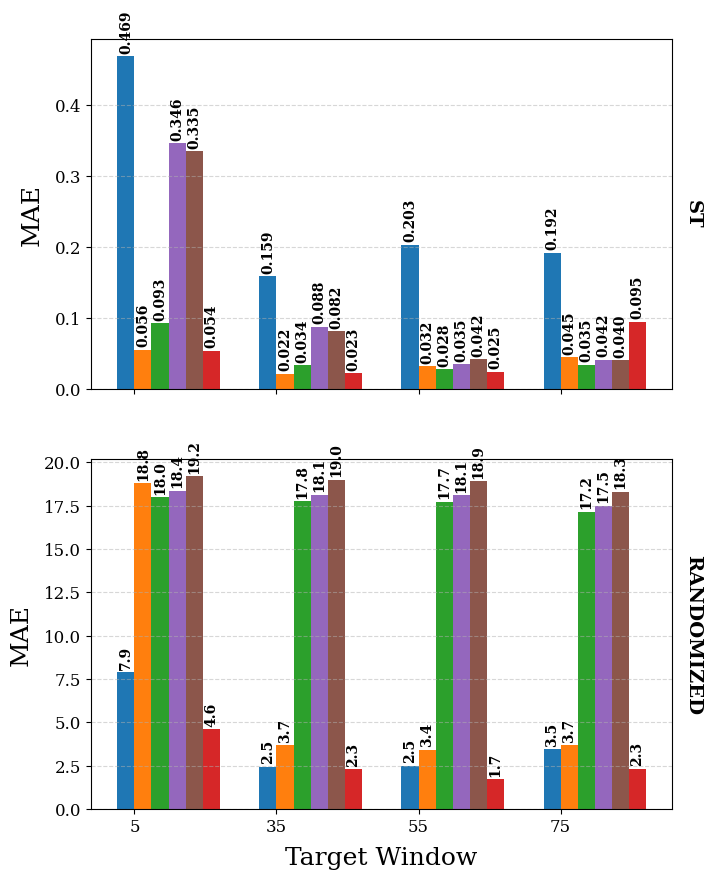

In [ ]:
# Extend to multiple target windows with subfigures for each dataset
target_windows = [5, 35, 55, 75]
# Parameters
bilstm_windows = [20, 30, 40, 50, 60]  # Different BiLSTM window lengths
width = 0.18  # Decrease bar width to accommodate more models

# Figure setup
datasets = ["st", "randomized"]
if len(datasets) == 0:
    raise ValueError("The 'datasets' list is empty. Please provide at least one dataset.")
fig, axes = plt.subplots(nrows=len(datasets), ncols=1,  # Horizontal layout
                        figsize=(7.5, 10), sharex=True)  # Reduced figure size
width = 0.12  # Narrower bars
annot_size = 7  # Smaller annotation text
label_size = 10  # Axis label size
title_size = 12  # Subplot title size

# Simplified color palette
colors = {
    "BiLSTM_20": "#1f77b4",
    "BiLSTM_30": "#ff7f0e",
    "BiLSTM_40": "#2ca02c",  # Reuse colors for better contrast
    "BiLSTM_50": "#9467bd",
    "BiLSTM_60": "#8c564b",
    "LightGBM": "#d62728"  # High-contrast for LightGBM
}

for i, ds_name in enumerate(datasets):
    print(f"\n\n=== Evaluating dataset: {ds_name} ===\n")
    handles = []
    labels = []
    ax = axes[i]
    bilstm_maes_dict = {f"BiLSTM_{w}": [] for w in bilstm_windows}
    lgbm_maes = []
    x_labels = []
    # Load parameters
    params_lgb = load_parameters("training/lightgbm.yaml", dataset_override=ds_name)
    params_bilstm = load_parameters("training/bilstm.yaml", dataset_override=ds_name)
    for target_window in target_windows:
        
        # Prepare BiLSTM data
        (_, _, _, _, test_s_bi, test_t_bi) = preprocess_and_window(
            data_path=params_bilstm.data_path,
            sequence_length=target_window,
            overlap=params_bilstm.overlap,
            normalize=params_bilstm.normalize,
            features=params_bilstm.features,
            labels=params_bilstm.labels,
            data_groupby=params_bilstm.data_groupby
        )

        # Prepare LightGBM data
        (_, _, _, _, test_s_lgb, test_t_lgb) = preprocess_and_window(
            data_path=params_lgb.data_path,
            sequence_length=target_window,
            overlap=params_lgb.overlap,
            normalize=params_lgb.normalize,
            features=params_lgb.raw_features,
            labels=params_lgb.labels,
            data_groupby=params_lgb.data_groupby
        )
        for bilstm_window in bilstm_windows:
            bilstm_path = f"result/models/bilstm/{ds_name}_bilstm_win{bilstm_window}.h5"
            if os.path.exists(bilstm_path):
                model_bi = tf.keras.models.load_model(bilstm_path, custom_objects={'mae': MeanAbsoluteError()})
            else:
                print(f"window size {bilstm_window} not found!")
                continue
            # No padding or splitting needed
            pred_bi = model_bi.predict(test_s_bi, verbose=0)
            mae_bi = mean_absolute_error(test_t_bi, pred_bi)
            print(f"  BILSTM Test MAE: {mae_bi:.6f}")
            # Collect MAEs for each BiLSTM window
            bilstm_maes_dict[f"BiLSTM_{bilstm_window}"].append(mae_bi if mae_bi is not None else np.nan)


        test_s_lgb = extract_features(test_s_lgb, params_lgb.raw_features, params_lgb.feature_list)
        lgbm_model_path = f"result/models/lightgbm/lgbm_{ds_name}_model.pkl"
        if os.path.exists(lgbm_model_path):
            with open(lgbm_model_path, "rb") as f:
                model_lgb = pickle.load(f)
            pred_lgb = model_lgb.predict(test_s_lgb)
            mae_lgb = mean_absolute_error(test_t_lgb, pred_lgb)
            print(f"  LightGBM Test MAE: {mae_lgb:.6f}")
        else:
            mae_lgb = None

        # Collect MAEs for LightGBM
        lgbm_maes.append(mae_lgb if mae_lgb is not None else np.nan)
        x_labels.append(f"Window {target_window}")
    # Modified plotting
    x = np.arange(len(target_windows))
    offset = -width * 0.5  # Reduced offset for compact layout
    decimal = .3 if ds_name == "st" else .1
    # Plot BiLSTM models
    for j, (bilstm_label, bilstm_maes) in enumerate(bilstm_maes_dict.items()):
        bars = ax.bar(x + offset + j*width, bilstm_maes, width, 
                     color=colors[bilstm_label], linewidth=0.5)
        handles.append(plt.Line2D([0], [0], color=colors[bilstm_label], lw=4))
        labels.append(bilstm_label)
        
        # Conditional value annotations
        for bar in bars:
            height = bar.get_height()
            #if height > 1.0:  # Only annotate large values
            ax.annotate(f'{height:{decimal}f}',  # Simplified format
                        (bar.get_x() + bar.get_width()/2, height),
                        textcoords="offset points",
                        xytext=(0, 2), ha='center', va='bottom',
                        fontsize=annot_size+3, rotation=90, fontweight='bold')

    # Plot LightGBM
    lgbm_bars = ax.bar(x + offset + len(bilstm_windows)*width, lgbm_maes, width,
                      color=colors["LightGBM"], linewidth=0.5)
    for bar in lgbm_bars:
        height = bar.get_height()
        ax.annotate(f'{height:{decimal}f}',  # Simplified format
                    (bar.get_x() + bar.get_width()/2, height),
                    textcoords="offset points",
                    xytext=(0, 2), ha='center', va='bottom',
                    fontsize=annot_size+3, rotation=90, fontweight='bold')
    # Add handle and label for LightGBM
    handles.append(plt.Line2D([0], [0], color=colors["LightGBM"], lw=4))
    labels.append("LightGBM")
    # Formatting
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MAE', fontsize=18)
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=label_size + 2)
    ax.tick_params(axis='y', labelsize=label_size + 2)
    #ax.set_xticklabels(x_labels, fontsize=18)
    ax.set_xticklabels([f'{w}' for w in target_windows], 
                      fontsize=label_size+2)
    ax.grid(True, linestyle='--', alpha=0.5, axis='y')


    # Add dataset name to the right of each subfigure
    ax.text(1.02, 0.5, ds_name.upper(), transform=ax.transAxes, fontsize=14, weight='bold', 
            ha='left', va='center', rotation=270)

# Add a single legend above the figures
#handles, labels = axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', fontsize=12, title_fontsize=14, ncol=len(handles))
# Shared X-axis label
axes[-1].set_xlabel('Target Window', fontsize=18)

# Add the legend above the figures
fig.legend(handles, labels, loc='upper center', fontsize=12, title_fontsize=14, ncol=3)
# Add a single legend above the figures
#handles, labels = axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', fontsize=12, title_fontsize=14, ncol=len(handles))
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the legend
plt.savefig('result/figures/unseen_window.pdf', bbox_inches='tight')
plt.show()

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


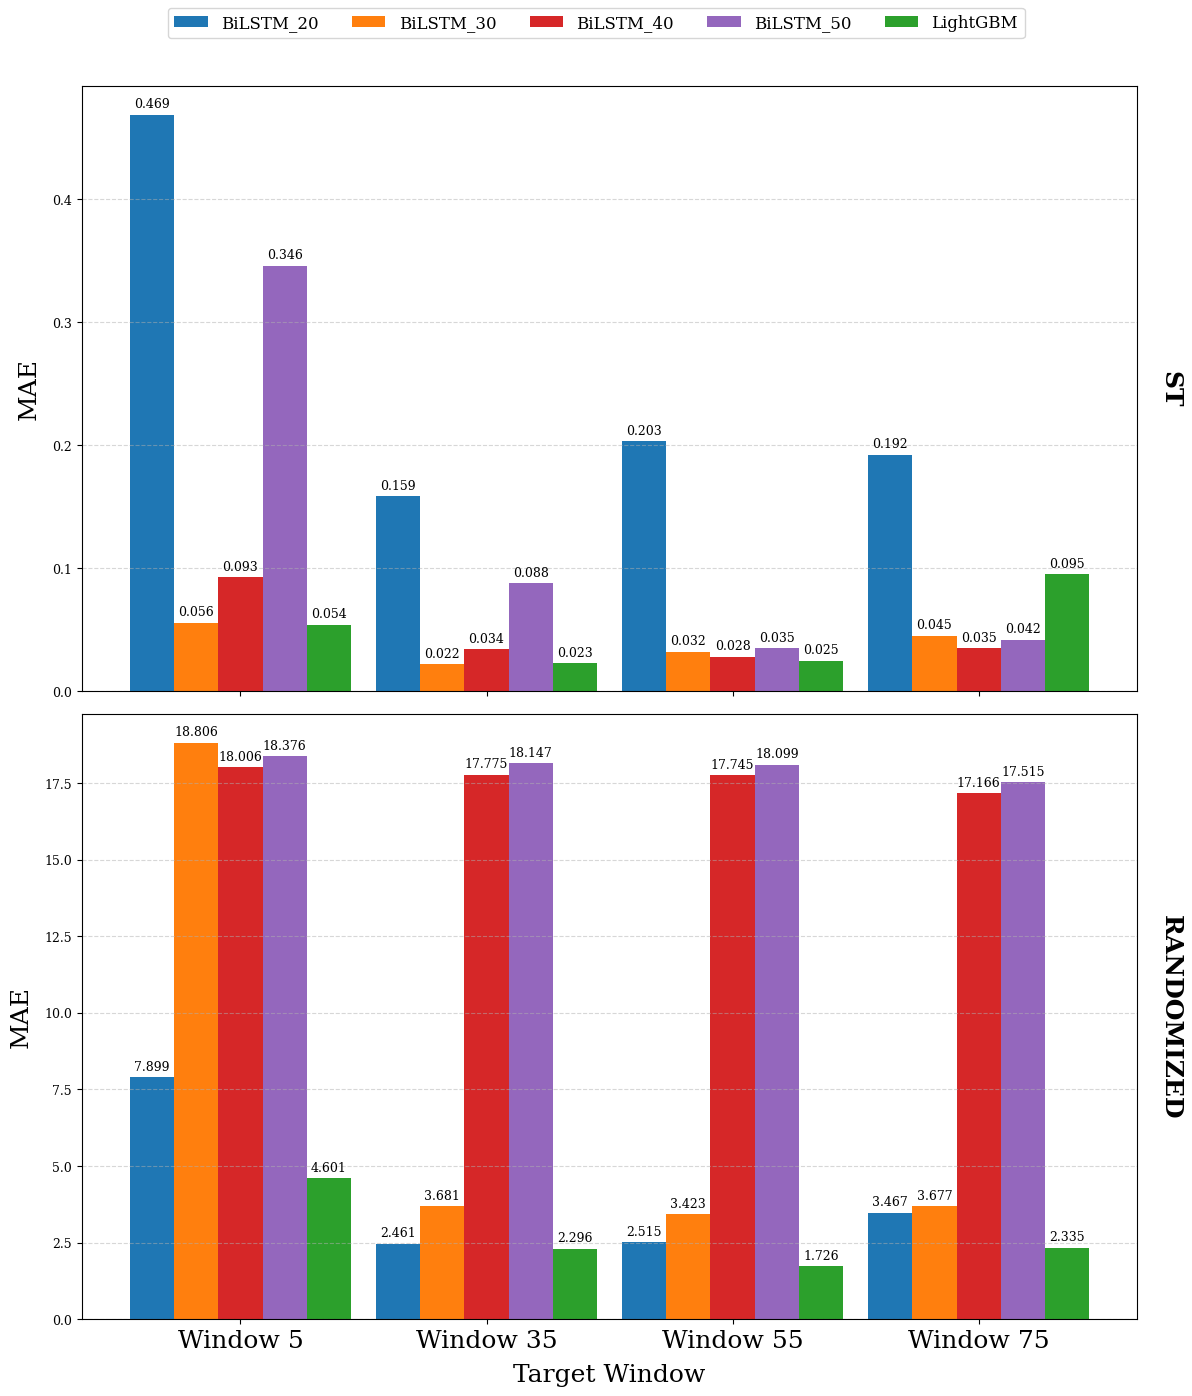

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.losses import MeanSquaredError

# Extend to multiple target windows with subfigures for each dataset
target_windows = [5, 35, 55, 75]
# Parameters
bilstm_windows = [20, 30, 40, 50]  # Different BiLSTM window lengths
width = 0.18  # Decrease bar width to accommodate more models

# Figure setup
datasets = ["st", "randomized"]
fig, axes = plt.subplots(nrows=len(datasets), ncols=1, figsize=(12, 14), sharex=True)
colors = {
    "BiLSTM_20": "#1f77b4", 
    "BiLSTM_30": "#ff7f0e", 
    "BiLSTM_40": "#d62728", 
    "BiLSTM_50": "#9467bd",  # New color added for BiLSTM_50
    "LightGBM": "#2ca02c"
}

for i, ds_name in enumerate(datasets):
    ax = axes[i]
    bilstm_maes_dict = {f"BiLSTM_{w}": [] for w in bilstm_windows}
    lgbm_maes = []
    x_labels = []
    # Load parameters
    params_lgb = load_parameters("training/lightgbm.yaml", dataset_override=ds_name)
    params_bilstm = load_parameters("training/bilstm.yaml", dataset_override=ds_name)
    for target_window in target_windows:
        
        # Prepare BiLSTM data
        (_, _, _, _, test_s_bi, test_t_bi) = preprocess_and_window(
            data_path=params_bilstm.data_path,
            sequence_length=target_window,
            overlap=params_bilstm.overlap,
            normalize=params_bilstm.normalize,
            features=params_bilstm.features,
            labels=params_bilstm.labels,
            data_groupby=params_bilstm.data_groupby
        )

        # Prepare LightGBM data
        (_, _, _, _, test_s_lgb, test_t_lgb) = preprocess_and_window(
            data_path=params_lgb.data_path,
            sequence_length=target_window,
            overlap=params_lgb.overlap,
            normalize=params_lgb.normalize,
            features=params_lgb.raw_features,
            labels=params_lgb.labels,
            data_groupby=params_lgb.data_groupby
        )
        for bilstm_window in bilstm_windows:
            bilstm_path = f"result/models/bilstm/{ds_name}_bilstm_win{bilstm_window}.h5"
            if os.path.exists(bilstm_path):
                model_bi = tf.keras.models.load_model(bilstm_path, custom_objects={'mae': MeanAbsoluteError()})
            else:
                print(f"window size {bilstm_window} not found!")
                continue
            '''if  target_window < bilstm_window:
                padded_shape = bilstm_window//target_window -1
                # Padding: Extend the sequence by duplicating the first few samples
                pad_len = bilstm_window - target_window 
                print(f"  Padding BiLSTM input from {target_window} to {bilstm_window} samples with {pad_len} samples.")
                print("Current shape:", test_s_bi.shape)
                
                test_bi = np.concatenate([test_s_bi, np.repeat(test_s_bi[:, :pad_len, :], repeats=padded_shape, axis=1)], axis=1)
                #test_bi = np.pad(test_s_bi, ((0, 0), (0, pad_len), (0, 0)), mode='constant')
                print("After Padding shape:", test_bi.shape)
                pred_bi = model_bi.predict(test_s_bi)
                mae_bi = mean_absolute_error(test_t_bi, pred_bi)
                print(f"  BiLSTM Test MAE (padded): {mae_bi:.6f}")
            elif target_window > bilstm_window:
                # Splitting: Predict in chunks and average the results
                num_chunks = target_window // bilstm_window
                chunk_preds = []
                for chunk_idx in range(0, target_window, bilstm_window):
                    if chunk_idx + bilstm_window > target_window:
                        print(f"  WARNING: Chunk index {chunk_idx} exceeds target window {target_window} when the biilstm window = {bilstm_window}. Skipping this chunk.")
                        continue
                    print(chunk_idx, target_window, bilstm_window)
                    #start_idx = chunk_idx * target_window
                    end_idx = chunk_idx + bilstm_window
                    chunk_data = test_s_bi[:, chunk_idx:end_idx, :].copy()
                    y_chunk = test_t_bi.copy()#ravel()[chunk_idx:end_idx]
                    chunk_pred = model_bi.predict(chunk_data)
                    mae_chunk = mean_absolute_error(y_chunk, chunk_pred)
                    chunk_preds.append(mae_chunk)
                #pred_bi = np.mean(chunk_preds, axis=0)
                print(f"  BiLSTM Test MAE (split): {chunk_preds}")
                mae_bi = np.mean(chunk_preds, axis=0)#mean_absolute_error(test_t_bi, pred_bi)
            else:'''
            # No padding or splitting needed
            pred_bi = model_bi.predict(test_s_bi)
            mae_bi = mean_absolute_error(test_t_bi, pred_bi)

            # Collect MAEs for each BiLSTM window
            bilstm_maes_dict[f"BiLSTM_{bilstm_window}"].append(mae_bi if mae_bi is not None else np.nan)


        test_s_lgb = extract_features(test_s_lgb, params_lgb.raw_features, params_lgb.feature_list)
        lgbm_model_path = f"result/models/lightgbm/lgbm_{ds_name}_model.pkl"
        if os.path.exists(lgbm_model_path):
            with open(lgbm_model_path, "rb") as f:
                model_lgb = pickle.load(f)
            pred_lgb = model_lgb.predict(test_s_lgb)
            mae_lgb = mean_absolute_error(test_t_lgb, pred_lgb)
        else:
            mae_lgb = None

        # Collect MAEs for LightGBM
        lgbm_maes.append(mae_lgb if mae_lgb is not None else np.nan)
        x_labels.append(f"Window {target_window}")

    # Plotting
    x = np.arange(len(target_windows))  # the label locations
    offset = -width * (len(bilstm_windows) / 2)  # Offset for multiple bars

    for j, (bilstm_label, bilstm_maes) in enumerate(bilstm_maes_dict.items()):
        ax.bar(x + offset + j * width, bilstm_maes, width, label=bilstm_label, color=colors[bilstm_label])

    ax.bar(x + offset + len(bilstm_windows) * width, lgbm_maes, width, label='LightGBM', color=colors["LightGBM"])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MAE', fontsize=18)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.5, axis='y')

    # Annotate bars with values
    for rects in ax.patches:
        height = rects.get_height()
        if not np.isnan(height):
            ax.annotate(f'{height:.3f}',
                        xy=(rects.get_x() + rects.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    # Add dataset name to the right of each subfigure
    ax.text(1.02, 0.5, ds_name.upper(), transform=ax.transAxes, fontsize=18, weight='bold', 
            ha='left', va='center', rotation=270)

# Shared X-axis label
axes[-1].set_xlabel('Target Window', fontsize=18)

# Add a single legend above the figures
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=12, title_fontsize=14, ncol=len(handles))

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the legend
plt.show()


In [26]:
# Define a function to plot results for multiple windows
def plot_results_for_windows(window_sizes, bilstm_model_dict, best_lgbm_model, test_dates, y_test_windows, preds_lgb, preds_bilstm):
    plt.figure(figsize=(14, 8))
    for i, w in enumerate(window_sizes):
        # Load BiLSTM model for the current window size
        bilstm_model_path = bilstm_model_dict.get(str(w))
        if bilstm_model_path:
            model_bilstm = tf.keras.models.load_model(bilstm_model_path, custom_objects={'mae': MeanSquaredError()})
            preds_bilstm = model_bilstm.predict(X_test_windows_bilstm)  # Update predictions for BiLSTM

        # Adjust dates for the current window size
        adjusted_dates = test_dates[:len(y_test_windows)]

        # Normalize capacities for plotting
        real_capacity = y_test_windows.ravel()
        normalized_real_capacity = real_capacity / np.max(real_capacity) * 100
        normalized_preds_lgb = preds_lgb.ravel() / np.max(real_capacity) * 100
        normalized_preds_bilstm = preds_bilstm.ravel() / np.max(real_capacity) * 100
        # Combine the values into a single DataFrame
        combined_df = pd.DataFrame({
            'Date': pd.to_datetime(adjusted_dates),
            'Real Capacity': normalized_real_capacity.ravel(),
            'LightGBM Predicted Capacity': normalized_preds_lgb,
            'BiLSTM Predicted Capacity': normalized_preds_bilstm
        })

        # Group by date and take the mean
        final = combined_df.groupby('Date').mean()
        # Plot real vs predicted for LightGBM and BiLSTM
        if i == 0:  # Plot real capacity and LightGBM only once
            plt.plot(final['Real Capacity'], label="Real Capacity", linewidth=5, linestyle="-", color="blue")
            plt.plot(final['LightGBM Predicted Capacity'], label="LightGBM Predicted Capacity", linewidth=4.5, linestyle="--", color="green")
        plt.plot(final['BiLSTM Predicted Capacity'], label=f"BiLSTM Predicted Capacity (Window {w})", linewidth=4.5, linestyle=":", color=f"C{i+2}")

    # Add labels, legend, and title
    plt.xlabel("Date", fontsize=16, fontweight='bold')
    plt.ylabel("Normalized Capacity (%)", fontsize=16, fontweight='bold')
    plt.title("Real vs Predicted Capacity (LightGBM and BiLSTM Across Windows)", fontsize=18, fontweight='bold')
    plt.legend(fontsize=14, loc='upper right', frameon=True, shadow=True, fancybox=True)
    # Enhance the plot
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.grid(visible=True, linestyle='--', alpha=0.8, linewidth=1.2)  # Enhance grid visibility
    plt.gca().set_facecolor('#f0f0f0')  # Set a light background color for better contrast
    plt.show()

# Call the function with updated parameters
plot_results_for_windows(window_sizes, model_bilstm_dict, model_lgb, test_dates, y_test_windows, preds_lgb, preds_bilstm)

NameError: name 'test_dates' is not defined

TypeError: Could not locate function 'mae'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mae', 'registered_name': 'mae'}

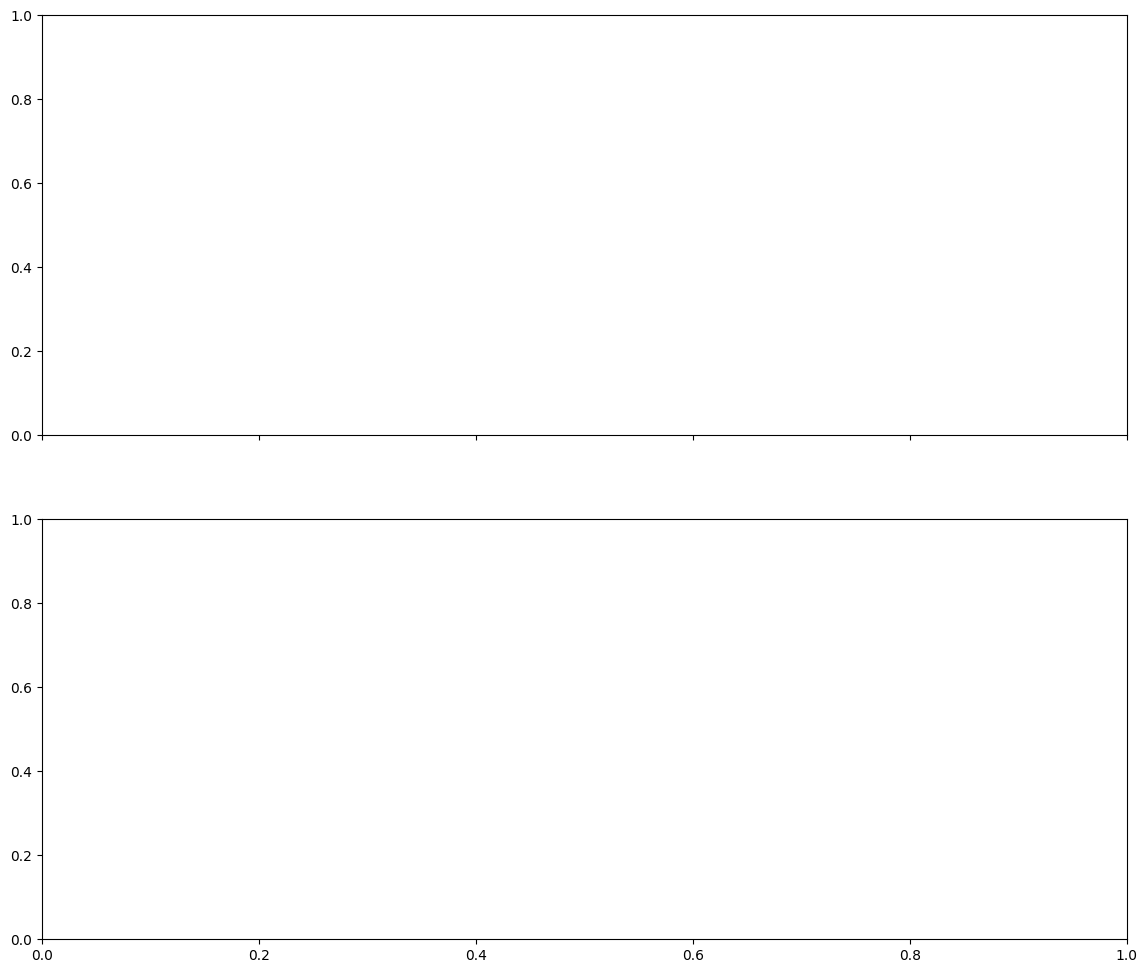

In [ ]:

# Adjust x-axis frequency and add subplots for multiple datasets#
# Adjust x-axis frequency and add subplots for multiple datasets
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), sharex=True)

for idx, dataset_name in enumerate(["st", "randomized"]):  # Replace with actual dataset names
    ax = axes[idx]
    # Define the bilstm_model_dict if not already defined
    bilstm_model_path = f'result/models/bilstm/{dataset_name}_bilstm_'
    bilstm_model_dict = {
        '10': f'{bilstm_model_path}win10.h5',
        '20': f'{bilstm_model_path}win20.h5',
        '30': f'{bilstm_model_path}win30.h5',
        '40': f'{bilstm_model_path}win40.h5',
        '50': f'{bilstm_model_path}win50.h5',
    }
    for i, w in enumerate(window_sizes):
        # Load BiLSTM model for the current window size
        bilstm_model_path = bilstm_model_dict.get(str(w))
        if bilstm_model_path:
            model_bilstm = tf.keras.models.load_model(bilstm_model_path, custom_objects={'mse': MeanSquaredError()})
            preds_bilstm = model_bilstm.predict(X_test_windows_bilstm)  # Update predictions for BiLSTM

        # Adjust dates for the current window size
        adjusted_dates = pd.to_datetime(test_dates[:len(y_test_windows)])
        if dataset_name == "st":
            # Normalize capacities for plotting
            real_capacity = y_test_windows.ravel()
            normalized_real_capacity = real_capacity / np.max(real_capacity) * 100
            normalized_preds_lgb = preds_lgb.ravel() / np.max(real_capacity) * 100
            normalized_preds_bilstm = preds_bilstm.ravel() / np.max(real_capacity) * 100

        # Plot real vs predicted for LightGBM and BiLSTM
        if i == 0:  # Plot real capacity and LightGBM only once
            ax.plot(adjusted_dates, normalized_real_capacity, label="Real Capacity", linestyle="-", color="blue")
            ax.plot(adjusted_dates, normalized_preds_lgb, label="LightGBM Predicted Capacity", linestyle="--", color="green")
        ax.plot(adjusted_dates, normalized_preds_bilstm, label=f"BiLSTM Predicted Capacity (Window {w})", linestyle=":", color=f"C{i+2}")

    # Enhance the subplot
    ax.set_title(f"{dataset_name} - Real vs Predicted Capacity")
    ax.set_ylabel("Normalized Capacity (%)")
    ax.legend()
    ax.grid(visible=True, linestyle='--', alpha=0.7)

# Set common x-axis label and adjust x-axis frequency
axes[-1].set_xlabel("Date")
for ax in axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(25))  # Reduce the frequency of x-axis ticks
    ax.tick_params(axis='x', rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()